In [29]:
import spacy
from spacy.training import Example

import pandas as pd
import nltk
from nltk.corpus import stopwords
from wordcloud import WordCloud
from collections import Counter

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

import torch
import torch.nn as nn
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader, Dataset

In [3]:
# Loading the dataset
SA_dataset = pd.read_csv('SA_dataset.csv')

## Data analysis

In [5]:
# Showing the first 5 rows of the dataset
SA_dataset.head()

,Review,Rating,Sentiment
0,**Possible Spoilers**,1,0
1,"Read the book, forget the movie!",2,0
2,**Possible Spoilers Ahead**,2,0
3,"What a script, what a story, what a mess!",2,0
4,I hope this group of film-makers never re-unites.,1,0


In [20]:
# Computing some statistics for the numerical columns
SA_dataset.describe()

,Rating,Sentiment
count,5000.000000,5000.000000
mean,5.902200,0.550000
std,3.653944,0.497543
min,1.000000,0.000000
25%,2.000000,0.000000
50%,7.000000,1.000000
75%,10.000000,1.000000
max,10.000000,1.000000


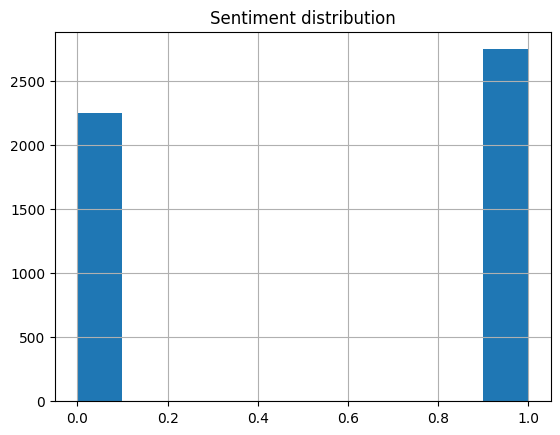

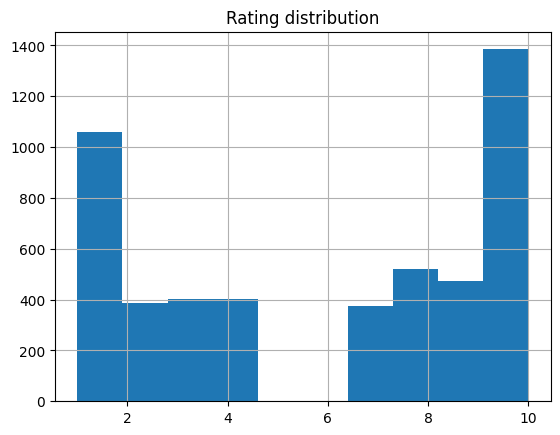

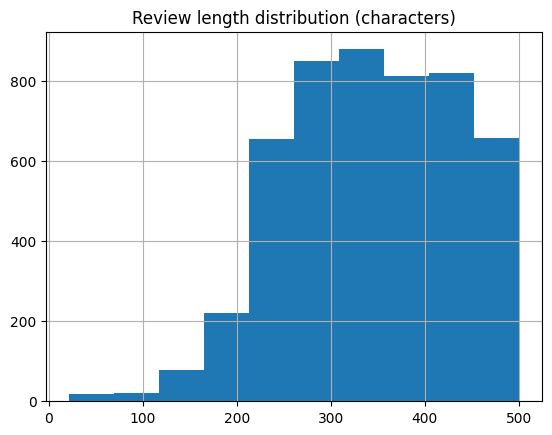

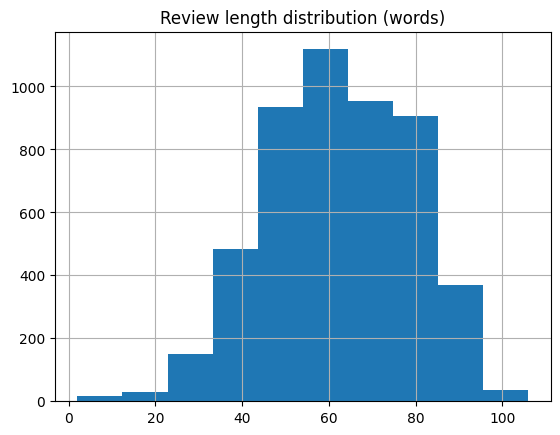

In [19]:
SA_dataset["Sentiment"].hist()
plt.title('Sentiment distribution')
plt.show()

SA_dataset["Rating"].hist()
plt.title('Rating distribution')
plt.show()

SA_dataset["Review"].str.len().hist()
plt.title('Review length distribution (characters)')
plt.show()

SA_dataset["Review"].str.split().apply(len).hist()
plt.title('Review length distribution (words)')
plt.show()

In [21]:
# Obtaining the frequency distribution of the words
freq_dist = SA_dataset['Review'].str.split(expand=True).unstack().dropna() # Splitting the reviews into words by spaces

# Loading the english stop words
StopWords = stopwords.words('english')

# Filtering the frequency distribution to remove the stop words and obtaining the 10 most common words
freq_dist = Counter({word:count for word, count in freq_dist.value_counts().items()
                     if word.lower() not in StopWords})
freq_dist.most_common(10)

[('movie', 3349),
 ('film', 1862),
 ('one', 1516),
 ('like', 1070),
 ('good', 1056),
 ('see', 849),
 ('great', 832),
 ('really', 774),
 ('movie.', 702),
 ('story', 688)]

In [22]:
# Showing the frequency distribution of the words
freq_dist

Counter({'movie': 3349,
         'film': 1862,
         'one': 1516,
         'like': 1070,
         'good': 1056,
         'see': 849,
         'great': 832,
         'really': 774,
         'movie.': 702,
         'story': 688,
         'bad': 643,
         'it.': 618,
         'even': 611,
         'ever': 610,
         'would': 597,
         'best': 528,
         'movies': 510,
         'time': 498,
         'watch': 497,
         'seen': 495,
         'acting': 491,
         'film.': 468,
         'much': 466,
         'think': 451,
         'make': 450,
         'made': 448,
         'get': 445,
         'could': 442,
         'plot': 434,
         'love': 420,
         '-': 419,
         'first': 415,
         'well': 383,
         'never': 365,
         'people': 360,
         'movie,': 353,
         'worst': 345,
         'better': 343,
         'little': 337,
         'saw': 311,
         'characters': 309,
         'still': 297,
         "I've": 296,
         'worth': 296,
 

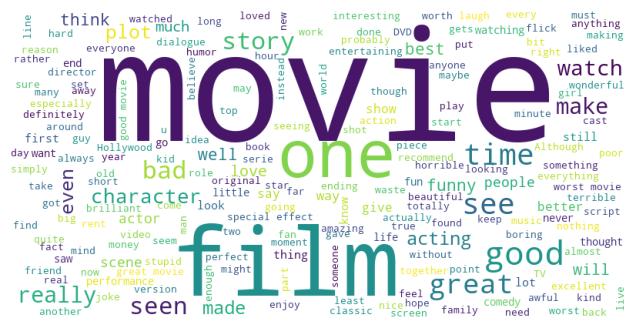

In [23]:
# Generating a word cloud for the reviews
def generate_wordcloud(text):
    wordcloud = WordCloud(width=800, height=400,
                          relative_scaling = 1.0,
                          background_color='white'
                          ).generate(text)

    fig = plt.figure(1, figsize=(8, 4))
    plt.axis('off')
    plt.imshow(wordcloud)
    plt.savefig("WordCloud.png")

text = " ".join(SA_dataset['Review'].values)
generate_wordcloud(text)

In [30]:
# Train-test split

X = SA_dataset['Review'].values
y = SA_dataset['Sentiment'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Classifier ussing spacy pipeline

In [26]:
# Loading the model
model = spacy.load('en_core_web_md')
model.pipe_names

['tok2vec', 'tagger', 'parser', 'attribute_ruler', 'lemmatizer', 'ner']

In [27]:
# Adding the text categorization component to the model pipeline
textcat = model.add_pipe('textcat', last=True)

In [28]:
# Generating an input example for the model, in order to initialize the text categorization component
input = Example.from_dict(model.make_doc('It was great'), {'cats': {'POSITIVE': 1.0, 'NEGATIVE': 0.0}})

# Initializing the text categorization component
textcat.initialize(lambda: [input], nlp=model)

In [31]:
# Create the optimizer
optimizer = model.resume_training()

In [32]:
# A function to transform the reviews into the neded format for the model
def create_examples(X, y):
    examples = []
    for text, label in zip(X, y):
        doc = model.make_doc(text)
        examples.append(Example.from_dict(doc, {'cats': {'POSITIVE': int(label), 'NEGATIVE': int(not label)}}))
    return examples

train_examples = create_examples(X_train, y_train)
test_examples = create_examples(X_test, y_test)

In [17]:
# Training the model
n_iter = 5
loss_history = []
for i in range(n_iter):
    losses = {}
    model.update(train_examples, losses=losses, drop=0.0, sgd=optimizer)
    print(losses)
    loss_history.append(losses['textcat'])

{'tok2vec': 0.0, 'tagger': 0.0, 'parser': 0.0, 'ner': 0.0, 'textcat': 0.25}


In [ ]:
plt.plot(loss_history)
plt.title('Training loss')
plt.show()

In [ ]:
# Showing some example prediction
model(test_examples[0].reference).cats

{'POSITIVE': 0.6279250979423523, 'NEGATIVE': 0.3720749318599701}

In [ ]:
# Testing the model
def evaluate_model(examples, y_test):
    correct = 0
    total = 0
    results = []
    for example, y in zip(examples, y_test):
        doc = example.reference
        prediction = model(doc)
        if prediction.cats['POSITIVE'] > prediction.cats['NEGATIVE']:
            prediction = 1
        else:
            prediction = 0
        if prediction == y:
            correct += 1
        total += 1
        results.append(prediction)
    return correct / total, results

accuracy, results = evaluate_model(test_examples, y_test)

In [ ]:
print("Accuracy: ", accuracy)
print(classification_report(y_test, results))

Accuracy:  0.736
              precision    recall  f1-score   support

           0       0.68      0.82      0.74       464
           1       0.81      0.66      0.73       536

    accuracy                           0.74      1000
   macro avg       0.74      0.74      0.74      1000
weighted avg       0.75      0.74      0.74      1000



In [ ]:
conf_matrix = confusion_matrix(y_test,
                               results)
sns.heatmap(conf_matrix, annot=True, fmt='d')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

## Classifier using LSTM

In [22]:
vocabulary = ['<PAD>'] + sorted(list({word for sentence in X for word in sentence.split()}))
word2idx = {word: idx for idx, word in enumerate(vocabulary)}
idx2word = {idx: word for word, idx in word2idx.items()}

vocabsize = len(vocabulary)

In [25]:
# Define the loader
class SentimentDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, index):

        return self.X[index], self.y[index]

def collate(batch):
    x, y = map(list, zip(*batch))
    x = [torch.tensor(seq) for seq in x]
    y = torch.tensor(y)
    padded_batch = pad_sequence(x, batch_first=True, padding_value=0)
    return padded_batch, y

X_train_idx = [[word2idx[word] for word in sentence.split()] for sentence in X_train]
X_test_idx = [[word2idx[word] for word in sentence.split()] for sentence in X_test]

train_dataset = SentimentDataset(X_train_idx, y_train)
test_dataset = SentimentDataset(X_test_idx, y_test)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, collate_fn=collate)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, collate_fn=collate)


In [123]:
class SentimentClassifier(nn.Module):
    def __init__(self, vocab_size, size_embedding, hidden_dim, output_dim, bidirectional, num_layers=1):
        super(SentimentClassifier, self).__init__()
        self.word_embeddings = nn.Embedding(vocab_size, size_embedding)
        self.rnn = nn.LSTM(size_embedding, hidden_dim, batch_first = True, bidirectional = bidirectional, num_layers=num_layers)
        self.fc = nn.Sequential(
            nn.Linear(hidden_dim, int(hidden_dim/2)),
            nn.Dropout(0.3),
            nn.ReLU(),
            nn.Linear(int(hidden_dim/2), output_dim)
        )
        self.numb_parameters = sum(p.numel() for p in self.parameters() if p.requires_grad)
        self.dropout = nn.Dropout(0.3)
        self.bidirectional = bidirectional
        if self.bidirectional:
            self.fc_bi = nn.Linear(hidden_dim*2, hidden_dim)
        print("Model initialized")
        print("Number of parameters: ", self.numb_parameters)
        self.num_layers = num_layers

    def forward(self, batch_sentences):
        embeddings = self.word_embeddings(batch_sentences)
        output, (hidden, cell) = self.rnn(embeddings)
        if self.bidirectional:
          hidden = hidden.view(self.num_layers, 2, batch_sentences.size(0), -1)
          hidden = hidden[-1, :, : , :]
          hidden = torch.cat((hidden[-2, :, :], hidden[-1, :, :]), dim=1)
          hidden = self.fc_bi(hidden)
          out = self.fc(self.dropout(hidden))
        else:
          out = self.fc(self.dropout(hidden.squeeze(0)))
        return out

# Define the model

model = SentimentClassifier(vocabsize,
                            size_embedding = 300,
                            hidden_dim = 200,
                            output_dim = 2,
                            bidirectional = True,
                            num_layers=2)

model.to('cuda' if torch.cuda.is_available() else 'cpu')

Model initialized
Number of parameters:  12797902


SentimentClassifier2(
  (word_embeddings): Embedding(36704, 300)
  (rnn): LSTM(300, 200, num_layers=2, batch_first=True, bidirectional=True)
  (fc): Sequential(
    (0): Linear(in_features=200, out_features=100, bias=True)
    (1): Dropout(p=0.3, inplace=False)
    (2): ReLU()
    (3): Linear(in_features=100, out_features=2, bias=True)
  )
  (dropout): Dropout(p=0.3, inplace=False)
  (fc_bi): Linear(in_features=400, out_features=200, bias=True)
)

In [124]:
def test(model, test_loader):
    # A function to generate the predictions given a model and a dataloader
    model.eval()
    y_test = []
    results = []
    for batch, sentiment in test_loader:
        batch = batch.to('cuda' if torch.cuda.is_available() else 'cpu')
        output = model(batch)
        # Get the max prediction
        _, prediction = torch.max(output, 1)
        results.append(prediction.detach().cpu())
        y_test.append(sentiment)

    results = torch.cat(results)
    y_test = torch.cat(y_test)
    return results, y_test


def train(model, train_loader, criterion, optimizer, n_epochs):
    # A function to train the model given a model, a dataloader, a criterion, an optimizer and the number of epochs
    model.train()
    squeduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.25)
    for epoch in range(n_epochs):
        for batch, y_train in train_loader:
            batch = batch.to('cuda' if torch.cuda.is_available() else 'cpu')
            y_train = y_train.to('cuda' if torch.cuda.is_available() else 'cpu')
            optimizer.zero_grad()
            output = model(batch)
            loss = criterion(output, y_train)
            loss.backward()
            optimizer.step()
        squeduler.step()
        print(f"Epoch {epoch + 1} / {n_epochs}, Loss: {loss.item()}")

    return model

In [125]:
# Setting adam optimizer and cross entropy loss function
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()
# Training the model
model = train(model, train_loader=train_loader,
      criterion=criterion,
      optimizer=optimizer,
      n_epochs=30)

Epoch 1 / 30, Loss: 0.633999764919281
Epoch 2 / 30, Loss: 0.429211288690567
Epoch 3 / 30, Loss: 0.28983572125434875
Epoch 4 / 30, Loss: 0.2658831477165222
Epoch 5 / 30, Loss: 0.15342456102371216
Epoch 6 / 30, Loss: 0.046508293598890305
Epoch 7 / 30, Loss: 0.0010456191375851631
Epoch 8 / 30, Loss: 0.0014411583542823792
Epoch 9 / 30, Loss: 0.0008786514517851174
Epoch 10 / 30, Loss: 0.0003872991946991533
Epoch 11 / 30, Loss: 0.0008921934058889747
Epoch 12 / 30, Loss: 0.0010920673375949264
Epoch 13 / 30, Loss: 0.0011716721346601844
Epoch 14 / 30, Loss: 0.001626787823624909
Epoch 15 / 30, Loss: 0.0006344062858261168
Epoch 16 / 30, Loss: 0.0016331624938175082
Epoch 17 / 30, Loss: 0.0005436364444904029
Epoch 18 / 30, Loss: 0.0011607714695855975
Epoch 19 / 30, Loss: 0.0003603558870963752
Epoch 20 / 30, Loss: 0.0004610646574292332
Epoch 21 / 30, Loss: 0.0003565983206499368
Epoch 22 / 30, Loss: 0.001096176914870739
Epoch 23 / 30, Loss: 0.0009482623427174985
Epoch 24 / 30, Loss: 0.000690153799951

In [127]:
results, y_test = test(model, test_loader)
print(classification_report(results, y_test))

              precision    recall  f1-score   support

           0       0.76      0.80      0.78       444
           1       0.83      0.80      0.82       556

    accuracy                           0.80      1000
   macro avg       0.80      0.80      0.80      1000
weighted avg       0.80      0.80      0.80      1000



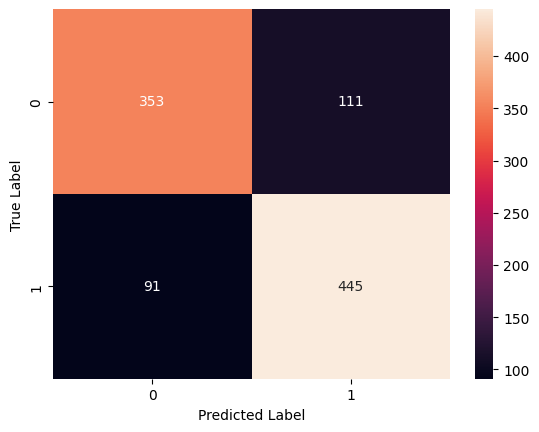

In [128]:
conf_matrix = confusion_matrix(y_test.cpu().numpy(),
                               results.cpu().numpy())
sns.heatmap(conf_matrix, annot=True, fmt='d')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()